In [9]:
#%% Import

import matplotlib
import matplotlib.pyplot as plt
import pymongo
import gridfs
import bz2
import Vis
import time
from bson import ObjectId
from Classes_Pymatgen import *
from AddDB import *
from View_Structures import *
from Database_Tools import get_file
from Helpers import get_FERE_chemical_potential
from scipy.stats import gmean
import numpy as np
import Make_Dos
import copy
from material_helpers import *
%matplotlib inline
try:
    client.close()
except:
    pass

(db,fs,client) = load_db()


In [1]:

import matplotlib
import matplotlib.pyplot as plt
import pymongo
import gridfs
import bz2
import Vis
import time
from bson import ObjectId
from Classes_Pymatgen import *
from AddDB import *
from View_Structures import *
from Database_Tools import get_file
from Helpers import get_FERE_chemical_potential
from scipy.stats import gmean
import numpy as np
import Make_Dos
import copy
from material_helpers import *
%matplotlib inline
try:
    client.close()
except:
    pass

(db,fs,client) = load_db()


In [2]:


match_criteria = {
    'pathway_count' : {'$exists' : True},
    'defect_type' : {'$exists' : False},
    'ts_type' : {'$exists' : False}
}

materials = [x['material'] for x in db.database.find(match_criteria).sort('material')]
# materials = [
# ['perovskite', 'bazro3'],
#              ['spinel', 'mnal2o4']
# ]
print(len(materials))
print(materials)


def get_matches(temp_match_criteria):
    temp_matches = list(db.database.find(temp_match_criteria).sort('energy'))
    key = 'defect_type'
    if len(temp_matches) > 1:
        #         view_multiple(temp_matches)
        print('Multiple Matches {}'.format(temp_match_criteria))
        # [print('{} {}\n'.format(x[key], x['energy'])) for x in temp_matches if key in x]
        # [print('{} {}\n'.format(x[key], x['energy'])) for x in temp_matches if key in x]
        print()
        return temp_matches[0]
    elif len(temp_matches) == 0:
        print('No Matches {}'.format(temp_match_criteria))
        return None
    else:
        return temp_matches[0]


mat_dict = {}
ts_dict = {}

for material in materials:
    l = 7
    match_criteria = {
        'defect_location': {'$exists': False},
        'material': material,
        'labels': {'$nin': ['surface', 'ts', 'interpolation', 'charged_defect']},
        'pathway_count': {'$exists': True},
        'poscar.structure.lattice.a': {'$gt': l},
        'ts_type': {'$exists': False},
        'energy' : {'$exists' : True},
        'misc_labels' : {'$nin' : ['kpts_div_2']},
    }
    base = get_matches(match_criteria)
    lb_criteria = {
        'labels': {'$nin': ['surface', 'interpolation'], '$all' : ['charged_defect']},
        'material': material,
        'ts_type': 'pc',
        'index': -1,
        'misc_labels' : {'$nin' : ['kpts_div_2']},
        'energy' : {'$exists' : True},
        'kpoints.kpoints' : base['kpoints']['kpoints'],
    }
    ub_criteria = {
        'labels': {'$nin': ['surface'], '$all' : ['charged_defect']},
        'material': material,
        'interpolation_direction': {'$exists': True},
        'index': -1,
        'misc_labels' : {'$nin' : ['kpts_div_2']},
        'kpoints.kpoints' : base['kpoints']['kpoints'],
    }

    match_criteria = {
        'labels': {'$nin': ['surface', 'ts', 'interpolation'], '$all' : ['charged_defect']},
        'defect_location': 'start',
        'material': material,
        'misc_labels' : {'$nin' : ['kpts_div_2']},
        'energy' : {'$exists' : True},
        'kpoints.kpoints' : base['kpoints']['kpoints'],
    }
    start = get_matches(match_criteria)

    if start:

        lb0_criteria = {
            'material': material,
            'ts_type': 'pc',
            'index': -1,
            'misc_labels': {'$nin': ['kpts_div_2']},
            'energy': {'$exists': True},
            'kpoints.kpoints': base['kpoints']['kpoints'],
            'labels': {'$nin': ['surface', 'interpolation', 'charged_defect']},
        }
        ub0_criteria = {
            'material': material,
            'interpolation_direction': {'$exists': True},
            'index': -1,
            'misc_labels': {'$nin': ['kpts_div_2']},
            'kpoints.kpoints': base['kpoints']['kpoints'],
            'labels': {'$nin': ['surface', 'charged_defect']},
        }

        match_criteria0 = {
            'defect_location': 'start',
            'material': material,
            'misc_labels': {'$nin': ['kpts_div_2']},
            'energy': {'$exists': True},
            'kpoints.kpoints': base['kpoints']['kpoints'],
            'labels': {'$nin': ['surface', 'ts', 'interpolation', 'charged_defect']},
        }
        start0 = get_matches(match_criteria0)

        mat_dict[material[1]] = {}
        ts_dict[material[1]] = {}

        mat_dict[material[1]]['base'] = base
        mat_dict[material[1]]['start'] = start
        mat_dict[material[1]]['start0'] = start0
        mat_dict[material[1]]['finals'] = []
        ts_dict[material[1]]['lb'] = []
        ts_dict[material[1]]['ub'] = []
        mat_dict[material[1]]['finals0'] = []
        ts_dict[material[1]]['lb0'] = []
        ts_dict[material[1]]['ub0'] = []
        for i in range(int(base['pathway_count'][0])):
            match_criteria['defect_location'] = 'final.{}'.format(i)
            match_criteria0['defect_location'] = 'final.{}'.format(i)
            lb_criteria['index'] = '{}'.format(i)
            ub_criteria['index'] = '{}'.format(i)
            lb0_criteria['index'] = '{}'.format(i)
            ub0_criteria['index'] = '{}'.format(i)

            final = get_matches(match_criteria)
            final0 = get_matches(match_criteria0)
            lb = get_matches(lb_criteria)
            ub = list(db.database.find(ub_criteria))
            lb0 = get_matches(lb0_criteria)
            ub0 = list(db.database.find(ub0_criteria))

            mat_dict[material[1]]['finals'].append(final)
            mat_dict[material[1]]['finals0'].append(final0)
            ts_dict[material[1]]['lb'].append(lb)
            ts_dict[material[1]]['ub'].append(ub)
            ts_dict[material[1]]['lb0'].append(lb0)
            ts_dict[material[1]]['ub0'].append(ub0)


In [3]:


match_criteria = {
    'pathway_count' : {'$exists' : True},
    'defect_type' : {'$exists' : False},
    'ts_type' : {'$exists' : False}
}

materials = [x['material'] for x in db.database.find(match_criteria).sort('material')]
# materials = [
# ['perovskite', 'bazro3'],
#              ['spinel', 'mnal2o4']
# ]
print(len(materials))
print(materials)


def get_matches(temp_match_criteria):
    temp_matches = list(db.database.find(temp_match_criteria).sort('energy'))
    key = 'defect_type'
    if len(temp_matches) > 1:
        #         view_multiple(temp_matches)
        print('Multiple Matches {}'.format(temp_match_criteria))
        # [print('{} {}\n'.format(x[key], x['energy'])) for x in temp_matches if key in x]
        # [print('{} {}\n'.format(x[key], x['energy'])) for x in temp_matches if key in x]
        print()
        return temp_matches[0]
    elif len(temp_matches) == 0:
        print('No Matches {}'.format(temp_match_criteria))
        return None
    else:
        return temp_matches[0]


mat_dict = {}
ts_dict = {}

for material in materials:
    l = 7
    match_criteria = {
        'defect_location': {'$exists': False},
        'material': material,
        'labels': {'$nin': ['surface', 'ts', 'interpolation', 'charged_defect']},
        'pathway_count': {'$exists': True},
        'poscar.structure.lattice.a': {'$gt': l},
        'ts_type': {'$exists': False},
        'energy' : {'$exists' : True},
        'misc_labels' : {'$nin' : ['kpts_div_2']},
    }
    base = get_matches(match_criteria)
    lb_criteria = {
        'labels': {'$nin': ['surface', 'interpolation'], '$all' : ['charged_defect']},
        'material': material,
        'ts_type': 'pc',
        'index': -1,
        'misc_labels' : {'$nin' : ['kpts_div_2']},
        'energy' : {'$exists' : True},
        'kpoints.kpoints' : base['kpoints']['kpoints'],
    }
    ub_criteria = {
        'labels': {'$nin': ['surface'], '$all' : ['charged_defect']},
        'material': material,
        'interpolation_direction': {'$exists': True},
        'index': -1,
        'misc_labels' : {'$nin' : ['kpts_div_2']},
        'kpoints.kpoints' : base['kpoints']['kpoints'],
    }

    match_criteria = {
        'labels': {'$nin': ['surface', 'ts', 'interpolation'], '$all' : ['charged_defect']},
        'defect_location': 'start',
        'material': material,
        'misc_labels' : {'$nin' : ['kpts_div_2']},
        'energy' : {'$exists' : True},
        'kpoints.kpoints' : base['kpoints']['kpoints'],
    }
    start = get_matches(match_criteria)

    if start:

        lb0_criteria = {
            'material': material,
            'ts_type': 'pc',
            'index': -1,
            'misc_labels': {'$nin': ['kpts_div_2']},
            'energy': {'$exists': True},
            'kpoints.kpoints': base['kpoints']['kpoints'],
            'labels': {'$nin': ['surface', 'interpolation', 'charged_defect']},
        }
        ub0_criteria = {
            'material': material,
            'interpolation_direction': {'$exists': True},
            'index': -1,
            'misc_labels': {'$nin': ['kpts_div_2']},
            'kpoints.kpoints': base['kpoints']['kpoints'],
            'labels': {'$nin': ['surface', 'charged_defect']},
        }

        match_criteria0 = {
            'defect_location': 'start',
            'material': material,
            'misc_labels': {'$nin': ['kpts_div_2']},
            'energy': {'$exists': True},
            'kpoints.kpoints': base['kpoints']['kpoints'],
            'labels': {'$nin': ['surface', 'ts', 'interpolation', 'charged_defect']},
        }
        start0 = get_matches(match_criteria0)

        mat_dict[material[1]] = {}
        ts_dict[material[1]] = {}

        mat_dict[material[1]]['base'] = base
        mat_dict[material[1]]['start'] = start
        mat_dict[material[1]]['start0'] = start0
        mat_dict[material[1]]['finals'] = []
        ts_dict[material[1]]['lb'] = []
        ts_dict[material[1]]['ub'] = []
        mat_dict[material[1]]['finals0'] = []
        ts_dict[material[1]]['lb0'] = []
        ts_dict[material[1]]['ub0'] = []
        for i in range(int(base['pathway_count'][0])):
            match_criteria['defect_location'] = 'final.{}'.format(i)
            match_criteria0['defect_location'] = 'final.{}'.format(i)
            lb_criteria['index'] = '{}'.format(i)
            ub_criteria['index'] = '{}'.format(i)
            lb0_criteria['index'] = '{}'.format(i)
            ub0_criteria['index'] = '{}'.format(i)

            final = get_matches(match_criteria)
            final0 = get_matches(match_criteria0)
            lb = get_matches(lb_criteria)
            ub = list(db.database.find(ub_criteria))
            lb0 = get_matches(lb0_criteria)
            ub0 = list(db.database.find(ub0_criteria))

            mat_dict[material[1]]['finals'].append(final)
            mat_dict[material[1]]['finals0'].append(final0)
            ts_dict[material[1]]['lb'].append(lb)
            ts_dict[material[1]]['ub'].append(ub)
            ts_dict[material[1]]['lb0'].append(lb0)
            ts_dict[material[1]]['ub0'].append(ub0)


196
[['h-barrier', 'al2o3'], ['h-barrier', 'al2o3'], ['spinel', 'alal2o4'], ['spinel', 'alv2o4'], ['spinel', 'alv2o4'], ['perovskite', 'bacoo3'], ['perovskite', 'bacoo3'], ['perovskite', 'bafeo3'], ['perovskite', 'bafeo3'], ['perovskite', 'bageo3'], ['perovskite', 'bageo3'], ['perovskite', 'bahfo3'], ['perovskite', 'bamn3po3'], ['perovskite', 'baseo3'], ['perovskite', 'basno3'], ['perovskite', 'basno3'], ['perovskite', 'batao3'], ['perovskite', 'bazro3'], ['perovskite', 'bazro3'], ['perovskite', 'bialo3'], ['perovskite', 'bicoo3'], ['perovskite', 'bicro3'], ['perovskite', 'bicuo3'], ['perovskite', 'bifeo3'], ['perovskite', 'bifeo3'], ['perovskite', 'bifeo3'], ['perovskite', 'bigao3'], ['perovskite', 'biino3'], ['perovskite', 'bimno3'], ['perovskite', 'bimno3'], ['perovskite', 'binio3'], ['perovskite', 'bisbo3'], ['perovskite', 'bisco3'], ['perovskite', 'bivo3'], ['h-barrier', 'bn'], ['perovskite', 'cacro3'], ['perovskite', 'cafeo3'], ['perovskite', 'cageo3'], ['perovskite', 'cageo3'], 

In [4]:

plot_all = True
label_all = False

try:
    for fig in figs:
        plt.close(fig)
    print('Cleaned Figs')
except:
    figs = []

linewidth = .75
exact_range = 0.1

ranges = []
error_min = []
error_max = []
# ax_pred.set_ylim([0, 4])
# ax_pred.set_xlim([0, 4])

# ax_all.plot([-1], [-1], color='blue', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
# ax_all.plot([-1], [-1], color='red', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
# ax_all.legend(['Perovskites', 'Spinels'], loc='upper left')
# ax_all.set_ylabel('Diffusion Barrier (eV)')
# ax_all.set_xlabel('Oxygen Vacancy Energy (eV)')
# 
# ax_all.set_ylim([0,4])
# ax_all.set_xlim([-2, 10])

dont_plot = []
plot = []

labels = [
    'laalo3',
    'lamn3po3',
    'sralo3',
    'srmn3po3',
]
labels = []
csv_dict = {}

csv_dict = Csv_dict()
label_list = []
lb = []
lb0 = []
avgs = []
avgs0 = []
err = []
err0 = []
bgs = []
minerr = 0
dont_plot = ['basno3', 'bisco3']
plotted_materials = []
mat_names = list(mat_dict.keys())
for material in mat_names:
# for material in ['yalo3']:
  if material not in dont_plot:
    label_list.append(material)
# for material in ['bivo3']:
    mat = mat_dict[material]
    thermo, lb_bars, ub_bars, delta = get_bars(mat, ts_dict[material])
    thermo0, lb0_bars, ub0_bars, delta = get_bars(mat, ts_dict[material], suffix='0')
    # print(lb_bars, lb0_bars)
    bars_list = [thermo, lb_bars, ub_bars]


    ranges = np.array(ub_bars) - np.array(lb_bars)
    ranges = np.array([ x if x > 0 else 0 for x in ranges])
    avg = np.array(lb_bars) + ranges/2 #type:np.array
    if max(avg) > 0:
        ranges0 = np.array(ub0_bars) - np.array(lb0_bars)
        ranges0 = np.array([ x if x > 0 else 0 for x in ranges0])
        avg0 = np.array(lb0_bars) + ranges0/2
        i = list(avg).index(min([ x for x in avg if x > 0 ]))
        lb.append(lb_bars[i])
        err.append(ranges[i])
        i0 = list(avg0).index(min([ x for x in avg0 if x > 0 ]))
        lb0.append(lb0_bars[i0])
        err0.append(max(ranges0[i0], minerr))
        avgs.append(avg[i])
        avgs0.append(avg0[i0])
        try:
            v_file = get_file(fs, mat['unit']['vasprun'])
            v = Vasprun(v_file)
            os.remove(v_file)
            bgs.append(str(v.get_band_structure().get_band_gap()['energy']))
        except:
            bgs.append('')
    else:
        lb.append(0)
        lb0.append(0)
        err.append(0)
        err0.append(0)
        avgs.append(0)
        avgs0.append(0)

figsize = (30,5)
font = {
    'family' : 'Arial',
    'size' : 12,
}
label_font = copy.deepcopy(font)
label_font['size'] = 14

tick_font = copy.deepcopy(font)
tick_font['size'] = 9
labels = {
    'bacoo3' : 'BaCoO$_3$',
    'bafeo3' : 'BaFeO$_3$'
}
def make_plot(bars_list, bottoms, legend=[], colors=['k', 'r', 'b'], ylim=None, ylabel='',label_list=label_list):
    width = .15 / len(bars_list)
    x = np.arange(len(bars_list[0]))
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white')

    for i, bars in enumerate(bars_list):
        rects = plt.errorbar(x + i * width, bars, color=colors[i], label=legend[i], yerr=np.array(bottoms[i])/2,
                             fmt='o', markersize=4, linewidth=10)
    lables = ax.set_xticklabels([ labels[x] if x in labels else x for x in label_list], fontdict=tick_font)
    ax.set_ylabel(ylabel, fontdict=label_font)

    ticks = ax.set_xticks(x + width * (len(bars_list)-1) / 2)
    # ticks = ax.set_xticks(x)
    if ylim:
        ax.set_ylim(ylim)
    plt.show()


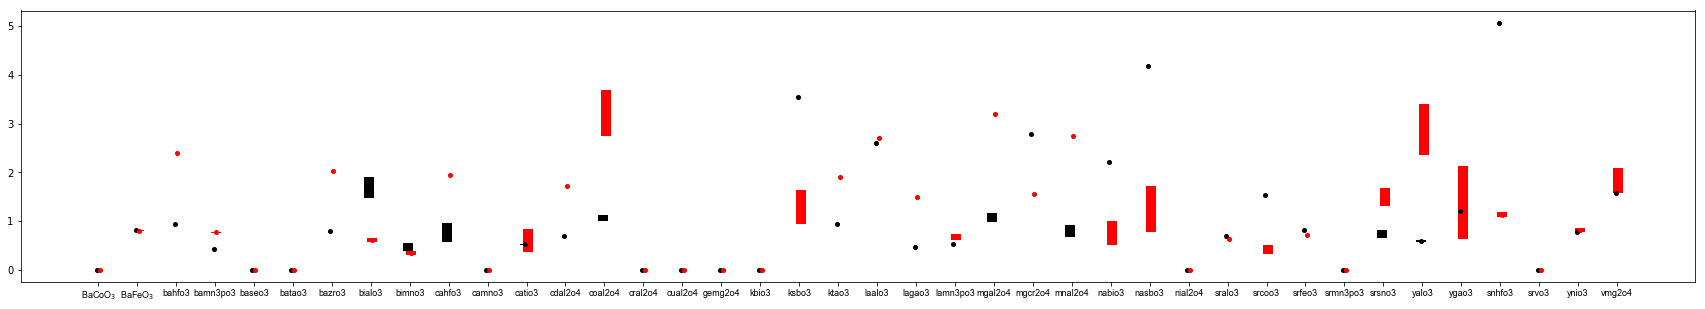

In [5]:
make_plot([avgs, avgs0], [err, err0], legend=['+2', '0'])


Cleaned Figs


D:\Users\RyanTrottier\AppData\Local\Continuum\miniconda3\envs\pymatgen\lib\site-packages\pymatgen\io\vasp\outputs.py:884: UserWarning: No POTCAR file with matching TITEL fields was found in C:\Users\RYANTR~1\AppData\Local\Temp
  " was found in {}".format(os.path.abspath(p)))


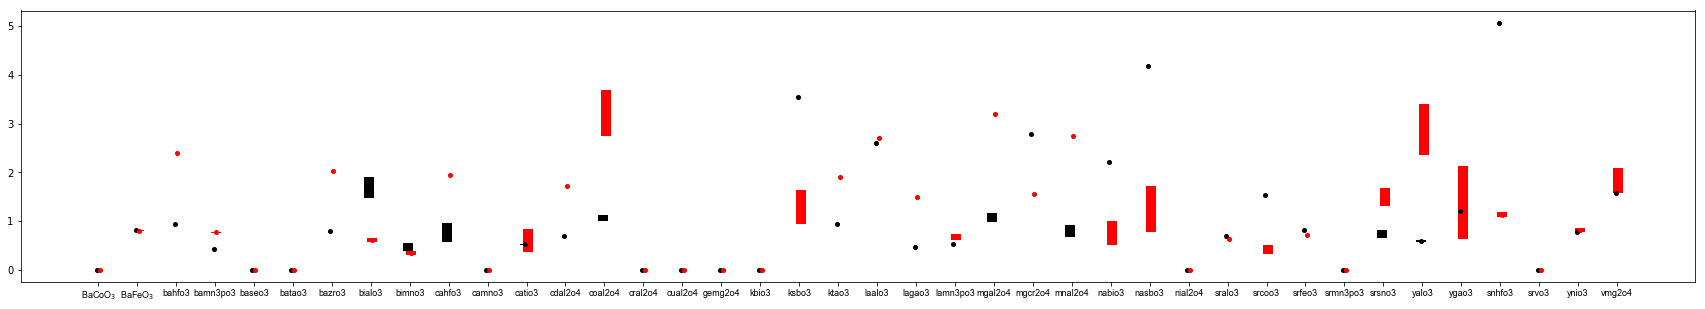

In [7]:

# for material in materials:
#     l = 7
#     match_criteria = {
#         'defect_location': {'$exists': False},
#         'material': material,
#         'labels': {'$nin': ['surface', 'ts', 'interpolation', 'charged_defect']},
#         'pathway_count': {'$exists': True},
#         'poscar.structure.lattice.a': {'$gt': l},
#         'ts_type': {'$exists': False},
#         'energy' : {'$exists' : True},
#         'misc_labels' : {'$nin' : ['kpts_div_2']},
#     }
#     base = get_matches(match_criteria)
#     match_criteria = {
#         'defect_location': {'$exists': False},
#         'material': material,
#         'labels': {'$nin': ['surface', 'ts', 'interpolation', 'charged_defect']},
#         'pathway_count': {'$exists': False},
#         'poscar.structure.lattice.a': {'$lt': l},
#         'ts_type': {'$exists': False},
#         'energy' : {'$exists' : True},
#         'misc_labels' : {'$nin' : ['kpts_div_2']},
#     }
#     unit = get_matches(match_criteria)
#     lb_criteria = {
#         'labels': {'$nin': ['surface', 'interpolation'], '$all' : ['charged_defect']},
#         'material': material,
#         'ts_type': 'pc',
#         'index': -1,
#         'misc_labels' : {'$nin' : ['kpts_div_2']},
#         'energy' : {'$exists' : True},
#         'kpoints.kpoints' : base['kpoints']['kpoints'],
#     }
#     ub_criteria = {
#         'labels': {'$nin': ['surface'], '$all' : ['charged_defect']},
#         'material': material,
#         'interpolation_direction': {'$exists': True},
#         'index': -1,
#         'misc_labels' : {'$nin' : ['kpts_div_2']},
#         'kpoints.kpoints' : base['kpoints']['kpoints'],
#     }
# 
#     match_criteria = {
#         'labels': {'$nin': ['surface', 'ts', 'interpolation'], '$all' : ['charged_defect']},
#         'defect_location': 'start',
#         'material': material,
#         'misc_labels' : {'$nin' : ['kpts_div_2']},
#         'energy' : {'$exists' : True},
#         'kpoints.kpoints' : base['kpoints']['kpoints'],
#     }
#     start = get_matches(match_criteria)
# 
#     if start:
# 
#         lb0_criteria = {
#             'material': material,
#             'ts_type': 'pc',
#             'index': -1,
#             'misc_labels': {'$nin': ['kpts_div_2']},
#             'energy': {'$exists': True},
#             'kpoints.kpoints': base['kpoints']['kpoints'],
#             'labels': {'$nin': ['surface', 'interpolation', 'charged_defect']},
#         }
#         ub0_criteria = {
#             'material': material,
#             'interpolation_direction': {'$exists': True},
#             'index': -1,
#             'misc_labels': {'$nin': ['kpts_div_2']},
#             'kpoints.kpoints': base['kpoints']['kpoints'],
#             'labels': {'$nin': ['surface', 'charged_defect']},
#         }
# 
#         match_criteria0 = {
#             'defect_location': 'start',
#             'material': material,
#             'misc_labels': {'$nin': ['kpts_div_2']},
#             'energy': {'$exists': True},
#             'kpoints.kpoints': base['kpoints']['kpoints'],
#             'labels': {'$nin': ['surface', 'ts', 'interpolation', 'charged_defect']},
#         }
#         start0 = get_matches(match_criteria0)
# 
#         mat_dict[material[1]] = {}
#         ts_dict[material[1]] = {}
# 
#         mat_dict[material[1]]['base'] = base
#         mat_dict[material[1]]['unit'] = unit
#         mat_dict[material[1]]['start'] = start
#         mat_dict[material[1]]['start0'] = start0
#         mat_dict[material[1]]['finals'] = []
#         ts_dict[material[1]]['lb'] = []
#         ts_dict[material[1]]['ub'] = []
#         mat_dict[material[1]]['finals0'] = []
#         ts_dict[material[1]]['lb0'] = []
#         ts_dict[material[1]]['ub0'] = []
#         for i in range(int(base['pathway_count'][0])):
#             match_criteria['defect_location'] = 'final.{}'.format(i)
#             match_criteria0['defect_location'] = 'final.{}'.format(i)
#             lb_criteria['index'] = '{}'.format(i)
#             ub_criteria['index'] = '{}'.format(i)
#             lb0_criteria['index'] = '{}'.format(i)
#             ub0_criteria['index'] = '{}'.format(i)
# 
#             final = get_matches(match_criteria)
#             final0 = get_matches(match_criteria0)
#             lb = get_matches(lb_criteria)
#             ub = list(db.database.find(ub_criteria))
#             lb0 = get_matches(lb0_criteria)
#             ub0 = list(db.database.find(ub0_criteria))
# 
#             mat_dict[material[1]]['finals'].append(final)
#             mat_dict[material[1]]['finals0'].append(final0)
#             ts_dict[material[1]]['lb'].append(lb)
#             ts_dict[material[1]]['ub'].append(ub)
#             ts_dict[material[1]]['lb0'].append(lb0)
#             ts_dict[material[1]]['ub0'].append(ub0)
